In [1]:
# imports
#from atracker import *
import atracker as atr
import ast
from importlib import reload
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
from scipy.optimize import minimize_scalar
from multiprocessing import Pool
import pickle
import matplotlib as mpl
import matplotlib.cm as cmx
from scipy.stats import chisquare
from cycler import cycler
from matplotlib.lines import Line2D
from pybt.trackers.boris import track_to_condition
import warnings
import time
from IPython.display import Markdown as md
from IPython.core.display import display, HTML, Markdown
# display(HTML("<style>.rendered_html { font-size: 17px; }</style>"))
# display(HTML("<style>.container { width:100% !important; }</style>"))
# def printmd(string):
#     display(Markdown(string))
warnings.filterwarnings('ignore')

# displaying matrices side by side
css = """
.output {
    flex-direction: row;
}
"""
HTML('<style>{}</style>'.format(css))

%matplotlib notebook

### Settings

In [2]:
# settings
en_per_unit_MeV = 26e3
particle = 'proton'
testing_sbend = False #False
read_fm = True
interpolate_fm = True
track_end_z_m = 2.5
fm_path = '/eos/project-b/beam-transfer-physics/public/data/ps-main-unit-type-u/maps/'
save_ref_traj = False


if testing_sbend:
    ang_glob = (0.0, 0.0)
    pos_glob = (0.0,  0.0   , -2.51)
else:
    ang_glob = (0.0682, 0.0)
    pos_glob = (6.490e-02,  0.0, -2.51e+00)

if read_fm:
    df = pd.read_csv(fm_path+'MUU_xy_grid.table',delim_whitespace=True, skiprows=8, names=['x', 'y', 'z', 'Bx', 'By', 'Bz']) #df is a pandas dataframe
    
    if testing_sbend:
        df['By']=0.31346770173998384
        df['Bx']=0.0
        df['Bz']=0.0
        print('CHANGED B!!!!!!')
    
    # mirroring the field map (wrt y=0)
    #QUESTION Why do we mirror the field map ?
    df_mir = df.copy() #copies a list instead of pointing to the same list
    df_mir[["y", "Bx", "Bz"]] = df_mir[["y", "Bx", "Bz"]].apply(np.negative) #multiply by minus 1 the y, Bx and Bz columns
    df_mir = df_mir.drop(df_mir[df_mir['y']==0.0].index) # .drop only select a smaller part of the data frame. Not sure what what the inner part selects

    fieldmap = pd.concat([df, df_mir]) # concatenate joins the two dataframes one after the other

    fieldmap.sort_values(by=['x','y'], inplace=True) #Sorts first the x column and then the y one. See https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html
    fieldmap['Bmod'] = np.sqrt(fieldmap['Bx']**2+fieldmap['By']**2+fieldmap['Bz']**2) #Calulates the length of the vector field and adds it into a additional column
    for axis in ['x', 'y', 'z']: #Loops through these three columns 
        axis_val = fieldmap[axis].unique() #List containing the unique values of each column
        print('In the direction {:} we have {:} values from {:} to {:} in steps of {:}'.format(axis, len(axis_val), axis_val.min(), axis_val.max(), np.unique(np.diff(axis_val)).mean().round(6)))
        #.diff calculates the a[i+1] - a[i]. Basically outputs the steps
        # then you take the mean of the unique steps and round to 6 figures after the decimal

    print('And average fields are')    
    print(fieldmap[['Bx', 'By', 'Bz']].mean()) #The syntax is you take the mean of each element in the list

if interpolate_fm:
    interp_fieldmap = atr.interpolate_fieldmap(fieldmap)

In the direction x we have 201 values from -0.76 to 0.76 in steps of 0.0076
In the direction y we have 201 values from -0.9 to 0.9 in steps of 0.009
In the direction z we have 527 values from -2.63 to 2.63 in steps of 0.01
And average fields are
Bx    8.162681e-19
By   -3.424371e-04
Bz    4.846168e-21
dtype: float64


In [3]:
def run_1part_to_cond(dist_info, time_step=4e-12, particle=particle, **kwargs):
    id_part, x0, p0, t0 = dist_info
    part = atr.Particle(particle)

    def func_B(x, time):
        Bxi_p = interp_fieldmap['Bx'](x).squeeze()
        Byi_p = interp_fieldmap['By'](x).squeeze()
        Bzi_p = interp_fieldmap['Bz'](x).squeeze()
        return np.array([Bxi_p, Byi_p, Bzi_p])

    # tracking conditions
    if testing_sbend:
        theta_deg = 1
        rho = part.get_rigidity(en_per_unit_MeV) / np.mean(fieldmap['By'])
        l_m = 2 * rho * np.sin(np.radians(theta_deg / 2))

        x1 = pos_glob[0] - rho
        z1 = pos_glob[2]
        x2 = pos_glob[0] - l_m * np.sin(np.radians(theta_deg))
        z2 = pos_glob[2] + l_m * np.cos(np.radians(theta_deg))
        _a, _b = atr.slope_intercept(z1, x1, z2, x2)
        track_is_inside = lambda x, p, t : x[0] > _a * x[2] + _b
    else:
        # PS case
        
        # track only reference particle
        if "conditions_ref" in kwargs:
            # a verticlal line at z = conditions_ref
            track_is_inside = lambda x, p, t : x[2] < kwargs["conditions_ref"]
        elif "conditions_all" in kwargs:
            # conditions_all is based on the previously run ref particle; line perpendicular to its trajectory
            (_a, _b) = kwargs["conditions_all"]
            track_is_inside = lambda x, p, t : x[0] < _a * x[2] + _b

    
    xs, ps, ts, _ = track_to_condition(track_is_inside,
                                       x = x0,
                                       p = p0,
                                       t = t0,
                                       mass = part.get_e0_eV(),
                                       n_charges = part.get_z(),
                                       time_step = time_step,
                                       return_full_track = True,
                                       func_B = func_B)
    
    return pd.DataFrame({'id': [id_part] * len(xs),
                         'k': list(range(0, len(xs))),
                         'x': np.array(xs)[:, 0],
                         'y': np.array(xs)[:, 1],
                         'z': np.array(xs)[:, 2],
                         'Px': np.array(ps)[:, 0],
                         'Py': np.array(ps)[:, 1],
                         'Pz': np.array(ps)[:, 2],
                         't': np.array(ts)})

### Generate set of 13 particles

In [4]:
# generate a set of 13 particles
a = atr.ATracker('proton') #Creates an object using class ATracker
dist_part_ref = {'dX': 0, 'dXP': 0, 'dY': 0, 'dYP': 0, 'dS': 0, 'en_MeV': en_per_unit_MeV, 'dt': 0} #La position de référence
dist13_local = a.generate_part13_local(dist_part_ref, dX=1e-3, dXP=1e-3, dY=1e-3, dYP=1e-3, dt=4e-12, dD=1e-3) #la distance de scanning
dist13_global = []
for key, value in dist13_local.items():
    dist13_global.append(a.get_dist_to_glob(dist = value, pos_glob0 = pos_glob, ang_glob0 = ang_glob))

### Run set of 13 particles

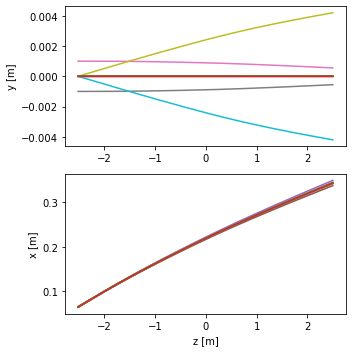

In [5]:
if not testing_sbend:
    # track the reference particle to track_end_z_m
    kwargs = {"conditions_ref": track_end_z_m}
    track_set_ref = run_1part_to_cond(dist13_global[0], **kwargs)
    track_ref = atr.Tracks([track_set_ref], particle)
    track_end_line = track_ref.get_track_condition()

    # tracks 13 particles to around track_end_z_m (to plane normal to the reference particle)
    def run_1part_to_cond_forPool(dist_info):
        kwargs = {"conditions_all": track_end_line}
        return run_1part_to_cond(dist_info, time_step=4e-12, particle=particle, **kwargs)

    with Pool(6) as p:
        tracks_set = p.map(run_1part_to_cond_forPool, dist13_global)

    
elif testing_sbend:
    with Pool(6) as p:
        tracks_set = p.map(run_1part_to_cond, dist13_global) 
        
tracks = atr.Tracks(tracks_set, particle)
if True:
    ax = tracks.plot_track(pid=0)
    for pid in range(0, len(dist13_global)):
        tracks.plot_track(pid=pid, legend = False, axes = ax)

if save_ref_traj:
    tracks.save_ref_to_csv('PS_26GeV_ref_trajectory.csv')

### Transport matrix

In [6]:
k_last = tracks_set[0].shape[0]-1

mat_f = tracks.get_transport_matrix(k = k_last, ret = 'mat') #Il faut que je regarde la fonction get_transport_matrix
mat_f_madx = tracks.get_madx_matrix(mat_arr = mat_f, k = k_last)
display(atr.style_df_transport_matrix(mat_f),
        atr.style_df_transport_matrix(mat_f_madx,
                                      index_names = ["x [m]", "px [1]", "y [m]", "py [1]", "T [m]", "PT [1]"],
                                      columns_names = ["x0 [m]", "px0 [1]", "y0 [m]", "py0 [1]", "T0 [m]", "PT0 [1]"]))

#mat_f_madx_dict = atr.matrix_arr_to_dict(mat_f_madx)

,x0 [m],xp0 [rad],y0 [m],yp0 [rad],T0 [m],D0 [1]
x [m],1.5159,5.9145,0.0000,0.0000,-0.0000,0.0688
xp [rad],0.2033,1.4532,0.0000,0.0000,-0.0000,0.0248
y [m],-0.0000,-0.0000,0.5552,4.2020,-0.0000,0.0000
yp [rad],-0.0000,-0.0000,-0.1580,0.6054,-0.0000,0.0000
T [m],-0.0236,-0.0465,0.0000,0.0000,1.0000,0.0058
D [1],-0.0000,0.0000,0.0000,0.0000,-0.0000,1.0000


,x0 [m],px0 [1],y0 [m],py0 [1],T0 [m],PT0 [1]
x [m],1.5159,5.9145,0.0000,0.0000,-0.0000,0.0688
px [1],0.2033,1.4532,0.0000,0.0000,-0.0000,0.0248
y [m],-0.0000,-0.0000,0.5552,4.2020,-0.0000,0.0000
py [1],-0.0000,-0.0000,-0.1580,0.6054,-0.0000,0.0000
T [m],-0.0236,-0.0465,0.0000,0.0000,1.0000,0.0058
PT [1],-0.0000,0.0000,0.0000,0.0000,-0.0000,1.0000



  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.06.01  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2020.09.01               +
  + Execution date: 2021.07.09 10:53:39      +
  ++++++++++++++++++++++++++++++++++++++++++++
{'s1': <Sequence: s1>}
enter Twiss module
  
open line - error with deltap:   0.000000E+00
initial orbit vector:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
final orbit vector:     0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
                10                 -0                  0                  0 

                q1                dq1            betxmax              dxmax 
      0.2327762651                  0        549.7113708       0.1926392345 

             dxrms             xcomax             xcorms                 q2 
    

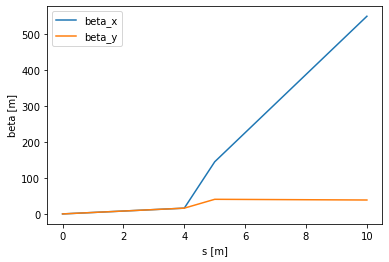


  Number of warnings: 0

  ++++++++++++++++++++++++++++++++++++++++++++
  +          MAD-X finished normally         +
  ++++++++++++++++++++++++++++++++++++++++++++


In [8]:
from cpymad.madx import Madx
madx = Madx(command_log="commandlog") #Writes the errors in this file once madx has quit
#madx.options(verbose=True, echo=True, debug=True)
madx.option(echo=False,warn=False) #Hides the output in the terminal

madx.beam(particle='proton', pc=25)

madx.command.sequence.clone('S1', l=10)
madx.command.endsequence()

madx.command.matrix.clone('CustomMatrix', L=1,
                                        rm11=mat_f[0][0], rm12=mat_f[0][1], rm13=mat_f[0][2], rm14=mat_f[0][3], rm15=mat_f[0][4], rm16=mat_f[0][5],
                                        rm21=mat_f[1][0], rm22=mat_f[1][1], rm23=mat_f[1][2], rm24=mat_f[1][3], rm25=mat_f[1][4], rm26=mat_f[1][5],
                                        rm31=mat_f[2][0], rm32=mat_f[2][1], rm33=mat_f[2][2], rm34=mat_f[2][3], rm35=mat_f[2][4], rm36=mat_f[2][5],
                                        rm41=mat_f[3][0], rm42=mat_f[3][1], rm43=mat_f[3][2], rm44=mat_f[3][3], rm45=mat_f[3][4], rm46=mat_f[3][5],
                                        rm51=mat_f[4][0], rm52=mat_f[4][1], rm53=mat_f[4][2], rm54=mat_f[4][3], rm55=mat_f[4][4], rm56=mat_f[4][5],
                                        rm61=mat_f[5][0], rm62=mat_f[5][1], rm63=mat_f[5][2], rm64=mat_f[5][3], rm65=mat_f[5][4], rm66=mat_f[5][5])

madx.command.seqedit(sequence='S1')
madx.command.install(element='M1', class_='CustomMatrix', at='4.5')
madx.command.endedit()

print(madx.sequence)

madx.use(sequence="S1")
twiss = madx.twiss(betx=1, bety=1)


%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(twiss.s, twiss.betx,label='beta_x')
plt.plot(twiss.s, twiss.bety,label='beta_y')
plt.xlabel('s [m]')
plt.ylabel('beta [m]')
plt.legend()
plt.show()


madx.quit()